<a href="https://colab.research.google.com/github/ElshadaiK/BIG_DATA/blob/main/big_data_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [238]:
%matplotlib inline

In [239]:
!pip install chart_studio bubbly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [240]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [241]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from bubbly.bubbly import bubbleplot
init_notebook_mode(connected=True)

from bokeh.plotting import figure, save
from bokeh.io import output_file, output_notebook, show
from bokeh.models import ColumnDataSource, GMapOptions,HoverTool
from bokeh.plotting import gmap

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU,LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


In [242]:
import plotly.io as pio 
pio.renderers.default = "colab"

In [243]:
## For Multiple Output in single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [244]:
data = pd.read_csv('../content/20140711.CSV') # here we need the CSV
data.shape
data.head(2)

(999998, 6)

,TripID,RouteID,StopID,StopName,WeekBeginning,NumberOfBoardings
0,23631,100,14156,181 Cross Rd,2013-06-30 00:00:00,1
1,23631,100,14144,177 Cross Rd,2013-06-30 00:00:00,1


In [245]:
out_geo = pd.read_csv('../content/output_geo.csv')
out_geo.head(2)

,accuracy,formatted_address,google_place_id,input_string,latitude,longitude,number_of_results,postcode,status,type
0,ROOFTOP,"181 Cross Rd, Westbourne Park SA 5041, Australia",ChIJKT7I9rbPsGoRVHMHkIy-Oyk,181 Cross Rd,-34.966656,138.592148,1,5041,OK,street_address
1,ROOFTOP,"177 Cross Rd, Westbourne Park SA 5041, Australia",ChIJ-VFZ87bPsGoRyfVgC5qbPpE,177 Cross Rd,-34.966607,138.592301,1,5041,OK,street_address


In [246]:
route = pd.read_csv("../content/routes.txt", sep=",")
route.head(2)

,route_long_name,route_color,route_id,route_url,route_desc,route_short_name,route_type,route_text_color
0,College Mall / East 3rd Street - Mon-Sat,006633,2480,NaN,Route 3 East provides great service to the sou...,3,3,FFFFFF
1,Campus Shuttle - Sat,A96836,2486,NaN,"If you live in Smallwood Plaza, the 10th and C...",6,3,FFFFFF


In [247]:
out_geo['dist_from_centre'] = out_geo[['latitude','longitude']].apply(lambda x: calc_dist(*x), axis=1)

In [248]:
##Fill the missing values with mode
out_geo['type'].fillna('street_address',inplace=True)
out_geo['type'] = out_geo['type'].apply(lambda x: str(x).split(',')[-1])

In [249]:
out_geo['type'].unique()

array(['street_address', 'transit_station', 'premise', 'political',
       'school', 'route', 'intersection', 'point_of_interest',
       'subpremise', 'real_estate_agency', 'university', 'travel_agency',
       'restaurant', 'supermarket', 'store', 'post_office'], dtype=object)

In [250]:
from math import sin, cos, sqrt, atan2, radians
def calc_dist(lat1,lon1):
    ## approximate radius of earth in km
    R = 6373.0
    dlon = radians(138.604801) - radians(lon1)
    dlat = radians(-34.921247) - radians(lat1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(-34.921247)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [251]:
'''Holidays--
2013-09-01,Father's Day
2013-10-07,Labour day
2013-12-25,Christmas day
2013-12-26,Proclamation Day
2014-01-01,New Year
2014-01-27,Australia Day
2014-03-10,March Public Holiday
2014-04-18,Good Friday
2014-04-19,Easter Saturday
2014-04-21,Easter Monday
2014-04-25,Anzac Day
2014-06-09,Queen's Birthday'''

def holiday_label (row):
    if row == datetime.date(2013, 9, 1) :
          return '1'
    if row == datetime.date(2013, 10, 6) :
          return '1'
    if row == datetime.date(2013, 12, 22) :
          return '2'
    if row == datetime.date(2013, 12, 29):
          return '1'
    if row  == datetime.date(2014, 1, 26):
          return '1'
    if row == datetime.date(2014, 3, 9):
          return '1'
    if row == datetime.date(2014, 4, 13) :
          return '2'
    if row == datetime.date(2014, 4, 20):
          return '2'
    if row == datetime.date(2014, 6, 8):
          return '1'
    return '0'

"Holidays--\n2013-09-01,Father's Day\n2013-10-07,Labour day\n2013-12-25,Christmas day\n2013-12-26,Proclamation Day\n2014-01-01,New Year\n2014-01-27,Australia Day\n2014-03-10,March Public Holiday\n2014-04-18,Good Friday\n2014-04-19,Easter Saturday\n2014-04-21,Easter Monday\n2014-04-25,Anzac Day\n2014-06-09,Queen's Birthday"

In [252]:
data['WeekBeginning'] = pd.to_datetime(data['WeekBeginning']).dt.date

In [253]:
data['holiday_label'] = data['WeekBeginning'].apply (lambda row: holiday_label(row))

**Data Aggregation**

In [254]:
data= pd.merge(data,out_geo,how='left',left_on = 'StopName',right_on = 'input_string')

In [255]:
data = pd.merge(data, route, how='left', left_on = 'RouteID', right_on = 'route_id')

Columns to keep for further analysis

In [256]:
col = ['TripID', 'RouteID', 'StopID', 'StopName', 'WeekBeginning','NumberOfBoardings','formatted_address',
      'latitude', 'longitude','postcode','type','route_desc','dist_from_centre','holiday_label']

In [257]:
data = data[col]

In [258]:
data.to_csv('Weekly_Boarding.csv',index=False)

In [259]:
grouped = data.groupby(['StopName','WeekBeginning','type']).agg({'NumberOfBoardings': ['sum', 'count','max']})
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]

In [260]:
st_week_grp = pd.DataFrame(grouped).reset_index()
st_week_grp.shape
st_week_grp.head()

(26359, 6)

,StopName,WeekBeginning,type,NumberOfBoardings_sum,NumberOfBoardings_count,NumberOfBoardings_max
0,1 Anzac Hwy,2013-06-30,street_address,131,41,44
1,1 Anzac Hwy,2013-07-07,street_address,118,34,28
2,1 Anzac Hwy,2013-07-14,street_address,91,29,31
3,1 Anzac Hwy,2013-07-21,street_address,71,33,9
4,1 Anzac Hwy,2013-07-28,street_address,88,38,13


In [261]:
st_week_grp1 = pd.DataFrame(st_week_grp.groupby('StopName')['WeekBeginning'].count()).reset_index()

In [262]:
aa=list(st_week_grp1[st_week_grp1['WeekBeginning'] == 54]['StopName'])

In [263]:
bb = st_week_grp[st_week_grp['StopName'].isin(aa)]

In [264]:
bb.to_csv('st_week_grp.csv', index=False)

**Data Exploration**

In [265]:
data.nunique()

TripID               3053
RouteID                34
StopID                880
StopName              529
WeekBeginning          54
NumberOfBoardings     154
formatted_address     409
latitude              392
longitude             391
postcode               60
type                    8
route_desc              0
dist_from_centre      393
holiday_label           3
dtype: int64

In [266]:
data.shape
data.columns
data.head(3)

(999998, 14)

Index(['TripID', 'RouteID', 'StopID', 'StopName', 'WeekBeginning',
       'NumberOfBoardings', 'formatted_address', 'latitude', 'longitude',
       'postcode', 'type', 'route_desc', 'dist_from_centre', 'holiday_label'],
      dtype='object')

,TripID,RouteID,StopID,StopName,WeekBeginning,NumberOfBoardings,formatted_address,latitude,longitude,postcode,type,route_desc,dist_from_centre,holiday_label
0,23631,100,14156,181 Cross Rd,2013-06-30,1,"181 Cross Rd, Westbourne Park SA 5041, Australia",-34.966656,138.592148,5041,street_address,NaN,5.180961,0
1,23631,100,14144,177 Cross Rd,2013-06-30,1,"177 Cross Rd, Westbourne Park SA 5041, Australia",-34.966607,138.592301,5041,street_address,NaN,5.172525,0
2,23632,100,14132,175 Cross Rd,2013-06-30,1,"175 Cross Rd, Westbourne Park SA 5041, Australia",-34.966758,138.592715,5041,street_address,NaN,5.180709,0


In [267]:
data.isnull().sum()

TripID                    0
RouteID                   0
StopID                    0
StopName                  0
WeekBeginning             0
NumberOfBoardings         0
formatted_address         0
latitude                  0
longitude                 0
postcode              79226
type                      0
route_desc           999998
dist_from_centre          0
holiday_label             0
dtype: int64

How Many different type of Unique Data in the dataset

In [268]:
data['WeekBeginning'].unique()

array([datetime.date(2013, 6, 30), datetime.date(2013, 7, 7),
       datetime.date(2013, 7, 14), datetime.date(2013, 7, 21),
       datetime.date(2013, 7, 28), datetime.date(2013, 8, 4),
       datetime.date(2013, 8, 11), datetime.date(2013, 8, 18),
       datetime.date(2013, 8, 25), datetime.date(2013, 9, 1),
       datetime.date(2013, 9, 8), datetime.date(2013, 9, 15),
       datetime.date(2013, 9, 22), datetime.date(2013, 9, 29),
       datetime.date(2013, 10, 6), datetime.date(2013, 10, 13),
       datetime.date(2013, 10, 20), datetime.date(2013, 10, 27),
       datetime.date(2013, 11, 3), datetime.date(2013, 11, 10),
       datetime.date(2013, 11, 17), datetime.date(2013, 11, 24),
       datetime.date(2013, 12, 1), datetime.date(2013, 12, 8),
       datetime.date(2013, 12, 15), datetime.date(2013, 12, 22),
       datetime.date(2013, 12, 29), datetime.date(2014, 1, 5),
       datetime.date(2014, 1, 12), datetime.date(2014, 1, 19),
       datetime.date(2014, 1, 26), datetime.date(20

**Data Visualization**

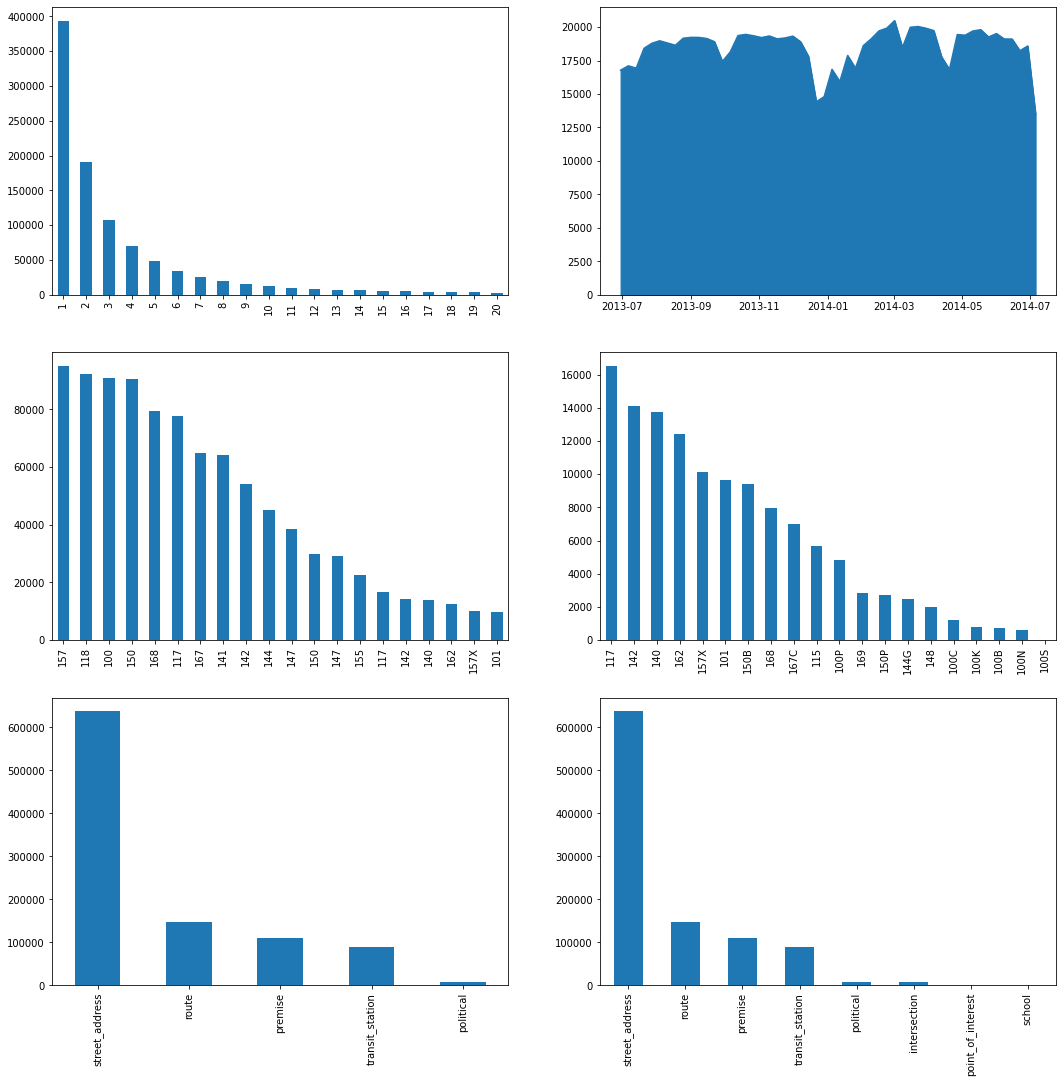

In [269]:
fig,axrr=plt.subplots(3,2,figsize=(18,18))

data['NumberOfBoardings'].value_counts().sort_index().head(20).plot.bar(ax=axrr[0][0])
data['WeekBeginning'].value_counts().plot.area(ax=axrr[0][1])
data['RouteID'].value_counts().head(20).plot.bar(ax=axrr[1][0])
data['RouteID'].value_counts().tail(20).plot.bar(ax=axrr[1][1])
data['type'].value_counts().head(5).plot.bar(ax=axrr[2][0])
data['type'].value_counts().tail(10).plot.bar(ax=axrr[2][1])

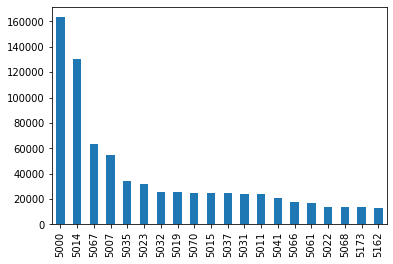

In [270]:
data['postcode'].value_counts().head(20).plot.bar()

In [271]:
bb_grp = data.groupby(['dist_from_centre']).agg({'NumberOfBoardings': ['sum']}).reset_index()
bb_grp.columns = bb_grp.columns.get_level_values(0)
bb_grp.head()
bb_grp.columns

,dist_from_centre,NumberOfBoardings
0,0.000018,483534
1,0.131368,17560
2,0.309089,59638
3,0.314937,41962
4,0.326005,55


Index(['dist_from_centre', 'NumberOfBoardings'], dtype='object')

In [272]:
trace0 = go.Scatter(
    x = bb_grp['dist_from_centre'],
    y = bb_grp['NumberOfBoardings'],mode = 'lines+markers',
    # name = "2 Unley Rd"
    name = 'X2 King William St'
    )

data1 = [trace0]
layout = dict(title = 'Distance Vs Number of boarding',
              xaxis = dict(title = 'Distance from centre'),
              yaxis = dict(title = 'Number of Boardings'))

fig = dict(data=data1, layout=layout)
iplot(fig)

**Inferences**:

As we move away from centre the number of Boarding decreases
There are cluster of bus stops near to the main Adelaide city as oppose to outside.so that's why most of boardings are near to center

In [287]:
bb_grp = bb.groupby(['StopName']).agg({'NumberOfBoardings_sum': ['sum']}).reset_index()['NumberOfBoardings_sum'].sort_values('sum')
bb_grp[100:110]
bb.groupby(['StopName']).agg({'NumberOfBoardings_sum': ['sum']}).reset_index().iloc[[392,396,40,370,272,177,147,77,178,401]]

,sum
373,2510
396,2579
40,2639
370,2648
272,2662
177,2702
147,2722
77,2728
178,2732
401,2743


,StopName,NumberOfBoardings_sum
,,sum
392,W1 North Tce,122028
396,Woodville,2579
40,12C Burbridge Rd,2639
370,H1 West Tce,2648
272,46 Military Rd,2662
177,27 West Lakes Bvd,2702
147,218 Findon Rd,2722
77,163 Cross Rd,2728
178,27T Tapleys Hill Rd,2732


In [289]:
source_1 = bb[bb['StopName'] == 'W1 North Tce'].reset_index(drop = True)
source_2 = bb[bb['StopName'] == 'Woodville'].reset_index(drop = True)
source_3 = bb[bb['StopName'] == '12C Burbridge Rd'].reset_index(drop = True)
source_4 = bb[bb['StopName'] == 'H1 West Tce'].reset_index(drop = True)
source_5 = bb[bb['StopName'] == '46 Military Rd'].reset_index(drop = True)

In [292]:
trace0 = go.Scatter(
    x = source_1['WeekBeginning'],
    y = source_1['NumberOfBoardings_sum'],mode = 'lines+markers',name = 'W1 North Tce')
trace1 = go.Scatter(
    x = source_2['WeekBeginning'],
    y = source_2['NumberOfBoardings_sum'],mode = 'lines+markers',name = 'Woodville')
trace2 = go.Scatter(
    x = source_3['WeekBeginning'],
    y = source_3['NumberOfBoardings_sum'],mode = 'lines+markers',name = '12C Burbridge Rd')
trace3 = go.Scatter(
    x = source_4['WeekBeginning'],
    y = source_4['NumberOfBoardings_sum'],mode = 'lines+markers',name = 'H1 West Tce')
trace4 = go.Scatter(
    x = source_5['WeekBeginning'],
    y = source_5['NumberOfBoardings_sum'],mode = 'lines+markers',name = '46 Military Rd')

data = [trace0,trace1,trace2,trace3,trace4]
layout = dict(title = 'Weekly Boarding Total',
              xaxis = dict(title = 'Week Number'),
              yaxis = dict(title = 'Number of Boardings'),
              shapes = [{# Holidays Record: 2013-09-01
'type': 'line','x0': '2013-09-01','y0': 0,'x1': '2013-09-02','y1': 3000,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2013-10-07
'type': 'line','x0': '2013-10-07','y0': 0,'x1': '2013-10-07','y1': 3000,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2013-12-25
'type': 'line','x0': '2013-12-25','y0': 0,'x1': '2013-12-26','y1': 3000,'line': {
        'color': 'rgb(55, 128, 191)','width': 3,'dash': 'dashdot'},},
              {# 2014-01-27
'type': 'line','x0': '2014-01-27','y0': 0,'x1': '2014-01-28','y1': 3000,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2014-03-10
'type': 'line','x0': '2014-03-10','y0': 0,'x1': '2014-03-11','y1': 3000,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2014-04-18
'type': 'line','x0': '2014-04-18','y0': 0,'x1': '2014-04-19','y1': 3000,'line': {
        'color': 'rgb(55, 128, 191)','width': 3,'dash': 'dashdot'},},
              {# 2014-06-09
'type': 'line','x0': '2014-06-09','y0': 0,'x1': '2014-06-10','y1': 3000,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},])
fig = dict(data=data, layout=layout)
iplot(fig)

**Inferences**:

W1 North Tce is the most busiest stop in the city. which having number of boardings per week more than 2k.
Vertical lines are the indicator of holidays which came within that week.
Whenever there is any Public holiday that week period have less than average number of people travelled from bus.

In [293]:
source_6 = bb[bb['StopName'] == '27 West Lakes Bvd'].reset_index(drop = True)
source_7 = bb[bb['StopName'] == '218 Findon Rd'].reset_index(drop = True)
source_8 = bb[bb['StopName'] == '163 Cross Rd'].reset_index(drop = True)
source_9 = bb[bb['StopName'] == '27T Tapleys Hill Rd'].reset_index(drop = True)
source_10 = bb[bb['StopName'] == 'Y1 East Tce'].reset_index(drop = True)

In [294]:
trace0 = go.Scatter(
    x = source_6['WeekBeginning'],
    y = source_6['NumberOfBoardings_sum'],mode = 'lines+markers',name = '27 West Lakes Bvd')
trace1 = go.Scatter(
    x = source_7['WeekBeginning'],
    y = source_7['NumberOfBoardings_sum'],mode = 'lines+markers',name = '218 Findon Rd')
trace2 = go.Scatter(
    x = source_8['WeekBeginning'],
    y = source_8['NumberOfBoardings_sum'],mode = 'lines+markers',name = '163 Cross Rd')
trace3 = go.Scatter(
    x = source_9['WeekBeginning'],
    y = source_9['NumberOfBoardings_sum'],mode = 'lines+markers',name = '27T Tapleys Hill Rd')
trace4 = go.Scatter(
    x = source_10['WeekBeginning'],
    y = source_10['NumberOfBoardings_sum'],mode = 'lines+markers',name = 'Y1 East Tce')

data = [trace0,trace1,trace2,trace3,trace4]
layout = dict(title = 'Weekly Boarding Total',
              xaxis = dict(title = 'Week Number'),
              yaxis = dict(title = 'Number of Boardings'),
              shapes = [{# Holidays Record: 2013-09-01
'type': 'line','x0': '2013-09-01','y0': 0,'x1': '2013-09-02','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2013-10-07
'type': 'line','x0': '2013-10-07','y0': 0,'x1': '2013-10-07','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2013-12-25
'type': 'line','x0': '2013-12-25','y0': 0,'x1': '2013-12-26','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 3,'dash': 'dashdot'},},
              {# 2014-01-27
'type': 'line','x0': '2014-01-27','y0': 0,'x1': '2014-01-28','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2014-03-10
'type': 'line','x0': '2014-03-10','y0': 0,'x1': '2014-03-11','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},
              {# 2014-04-18
'type': 'line','x0': '2014-04-18','y0': 0,'x1': '2014-04-19','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 3,'dash': 'dashdot'},},
              {# 2014-06-09
'type': 'line','x0': '2014-06-09','y0': 0,'x1': '2014-06-10','y1': 80,'line': {
        'color': 'rgb(55, 128, 191)','width': 1,'dash': 'dashdot'},},])

fig = dict(data=data, layout=layout)
iplot(fig)

**Plot Using Bubbly**

In [295]:
bb1=bb.copy()

In [296]:
## Label encode the Date type for easy Plotting
le = LabelEncoder()
bb1['WeekBeginning'] = le.fit_transform(bb1['WeekBeginning'])

In [297]:
figure = bubbleplot(dataset=bb1, x_column='NumberOfBoardings_sum', y_column='NumberOfBoardings_count', 
    bubble_column='StopName', time_column='WeekBeginning', size_column='NumberOfBoardings_max',
    color_column='type', 
    x_title="Total Boardings", y_title="Frequency Of Boardings",show_slider=True,
    title='Adelaide Weekly Bus Transport Summary 2D',x_logscale=True, scale_bubble=2,height=650)
iplot(figure, config={'scrollzoom': True})


In the graph above, the size corresponds to the maximum number of people board at single time and the Total boardings and Frequency of boardings with stop name can be seen by hovering over the cursor on the bubbles.

The animated bubble charts convey a great deal of information since they can accomodate upto seven variables in total, namely:



*   X-axis (Total Boardings per week)
*   Y-axis (Frequency of Bus Boarding)
*   Bubbles (Bus stop name)
*   Time (in week period)
*   Size of bubbles (maximum number of people board at single time)
*   Color of bubbles (Type of Bus stop)



Let's plot for first 30 stops.

In [298]:
figure = bubbleplot(dataset=bb1[bb1['StopName'].isin(bb1['StopName'].unique()[:30])], x_column='NumberOfBoardings_sum', y_column='NumberOfBoardings_count', 
    bubble_column='StopName', time_column='WeekBeginning', size_column='NumberOfBoardings_max',
    color_column='type', 
    x_title="Total Boardings", y_title="Frequency Of Boardings",show_slider=False,
    title='Adelaide Weekly Bus Transport Summary 2D',x_logscale=True, scale_bubble=2,height=650)

iplot(figure, config={'scrollzoom': True})

3D Bubble Plot with 6 different variables & there Relationship

**The Slidebar represent the week instead of year**

In [299]:
figure = bubbleplot(dataset=bb1, x_column='NumberOfBoardings_sum', y_column='NumberOfBoardings_count', 
    bubble_column='StopName', time_column='WeekBeginning', z_column='NumberOfBoardings_max',
    color_column='type',show_slider=False, 
    x_title="Total Boardings", y_title="Frequency Of Boardings", z_title="Maximum Boardings",
    title='Adelaide Weekly Bus Transport Summary 3D', x_logscale=True, z_logscale=True,y_logscale=True,
    scale_bubble=0.8, marker_opacity=0.8, height=700)

iplot(figure, config={'scrollzoom': True})

Inferences:

Total Boardings are directly propotional to the frequency of bus boarding.
In 3D Plot we can see the cluster of address type.

Propositions 

Rate of change in the traffic pattern in all different bus stops.

In [300]:
d=[]
for i in bb['StopName'].unique():
    d.append({'StopName': i,'Boarding_sum':np.sum(bb[bb['StopName'] == i]['NumberOfBoardings_sum'].pct_change())/54,
             'Boarding_count':np.sum(bb[bb['StopName'] == i]['NumberOfBoardings_count'].pct_change())/54,
             'Boarding_max':np.sum(bb[bb['StopName'] == i]['NumberOfBoardings_max'].pct_change())/54})
pct_chng = pd.DataFrame(d)


In [301]:
pct_chng['Boarding_sum'].nlargest(5)
print()
pct_chng['Boarding_sum'].nsmallest(5)
print()
pct_chng[pct_chng['Boarding_sum']<0].shape
pct_chng.iloc[[80,386,83,22,166]]

80     2.441739
386    1.997879
83     1.400415
22     0.597264
166    0.515908
Name: Boarding_sum, dtype: float64

266   -0.015455
271   -0.007067
142   -0.001782
409   -0.001588
183   -0.000461
Name: Boarding_sum, dtype: float64

(5, 4)

,StopName,Boarding_sum,Boarding_count,Boarding_max
80,165A Cross Rd,2.441739,0.276785,3.705941
386,T3 Grenfell St,1.997879,0.182228,1.034706
83,169 Cross Rd,1.400415,0.459175,0.501542
22,11 Sir Donald Bradman Dr,0.597264,0.188183,0.376836
166,24 Marion Rd,0.515908,0.252469,0.466343


Inferences:

These 5 stops: 165A Cross Rd, T3 Grenfell St, 169 Cross Rd, 11 Sir Donald Bradman Dr, 24 Marion Rd	having the largest percent increase.
There are 5 Bus stops where number of boardings have decreased.
The number of busses can be found by taking the number of boarding divided by bus capacity which can take as 50.

**Predictive Modelling**

In [302]:
bb1 = pd.merge(bb, out_geo, how='left', left_on = 'StopName', right_on = 'input_string')

In [303]:
bb1['holiday_label'] = bb1['WeekBeginning'].apply (lambda row: holiday_label(row))

In [304]:
##Final 11 features have been used for the forecastng.
cols = ['StopName','WeekBeginning','type_x','NumberOfBoardings_sum','NumberOfBoardings_count','NumberOfBoardings_max','latitude','longitude','postcode','dist_from_centre','holiday_label']
bb1=bb1[cols]
bb1.shape
bb1.head()

(22194, 11)

,StopName,WeekBeginning,type_x,NumberOfBoardings_sum,NumberOfBoardings_count,NumberOfBoardings_max,latitude,longitude,postcode,dist_from_centre,holiday_label
0,1 Anzac Hwy,2013-06-30,street_address,131,41,44,-34.942418,138.58183,5035,3.151684,0
1,1 Anzac Hwy,2013-07-07,street_address,118,34,28,-34.942418,138.58183,5035,3.151684,0
2,1 Anzac Hwy,2013-07-14,street_address,91,29,31,-34.942418,138.58183,5035,3.151684,0
3,1 Anzac Hwy,2013-07-21,street_address,71,33,9,-34.942418,138.58183,5035,3.151684,0
4,1 Anzac Hwy,2013-07-28,street_address,88,38,13,-34.942418,138.58183,5035,3.151684,0


In [305]:
##Replace all Nan by Mode
for i in bb1.columns:
    bb1[i].fillna(bb1[i].mode()[0], inplace=True)
bb1[["postcode", "holiday_label"]] = bb1[["postcode", "holiday_label"]].apply(pd.to_numeric)

In [306]:
le = LabelEncoder()
bb1['StopName'] = le.fit_transform(bb1['StopName'])
bb1['type_x'] = le.fit_transform(bb1['type_x'])

Split into Train Test for Modelling further

In [307]:
train = bb1[bb1['WeekBeginning'] < datetime.date(2014, 6, 1)]
test = bb1[bb1['WeekBeginning'] >= datetime.date(2014, 6, 1)]
train.shape
test.shape

(19728, 11)

(2466, 11)

In [308]:
le = LabelEncoder()
train['WeekBeginning'] = le.fit_transform(train['WeekBeginning'])
test['WeekBeginning'] = le.fit_transform(test['WeekBeginning'])

In [309]:
tr_col = ['StopName', 'WeekBeginning', 'type_x', 'latitude',
       'longitude', 'postcode', 'dist_from_centre', 'holiday_label']
train_sum_y = train[['StopName','NumberOfBoardings_sum']]
train_count_y = train[['StopName','NumberOfBoardings_count']]
train_max_y = train[['StopName','NumberOfBoardings_max']]
train_x = train[tr_col]
test_x = test[tr_col]

test_sum_y = test[['StopName','NumberOfBoardings_sum']]
test_count_y = test[['StopName','NumberOfBoardings_count']]
test_max_y = test[['StopName','NumberOfBoardings_max']]

Modelling using regression models.

LGBMRegressor and 
Gru

**Using LGBMRegressor**

In [312]:
from sklearn.ensemble import RandomForestRegressor
model = lgb.LGBMRegressor()
# model = lgb.LGBMRegressor(max_depth=10,learning_rate=0.0227,n_estimators=195,num_leaves=11,reg_alpha=1.5764,reg_lambda=0.0478,subsample=0.7776,colsample_bytree=0.7761)
model.fit(train_x.values,train_sum_y['NumberOfBoardings_sum'].values)
preds = model.predict(test_x.values)

LGBMRegressor()

In [313]:
rms = sqrt(mean_squared_error(test_sum_y['NumberOfBoardings_sum'].values, preds))
rms

99.24381802075845

In [314]:
test_sum_y.values[:15]
preds[:15]

array([[ 0, 49],
       [ 0, 45],
       [ 0, 49],
       [ 0, 79],
       [ 0, 66],
       [ 0, 51],
       [ 1,  7],
       [ 1,  8],
       [ 1,  7],
       [ 1,  6],
       [ 1,  5],
       [ 1,  9],
       [ 2, 32],
       [ 2, 12],
       [ 2, 13]])

array([70.89038118, 58.00997426, 64.97772647, 81.56874156, 88.68405151,
       88.68405151,  3.66185625, 16.63574551, -4.98299828,  7.60514664,
       12.90775065, 12.90775065, 26.52565024, 37.11351982, 21.43385769])

Text(0.5, 1.0, 'LightGBM - Feature Importance')

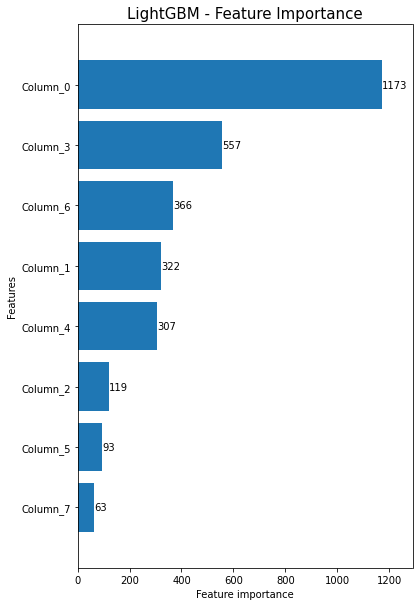

In [315]:
fig, ax = plt.subplots(figsize=(6,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

<Figure size 1080x360 with 0 Axes>

Text(0, 0.5, 'Total Number of Boarding')

Text(0.5, 0, 'Index')

Text(0.5, 1.0, 'Comparison Between Prediction & True Values')

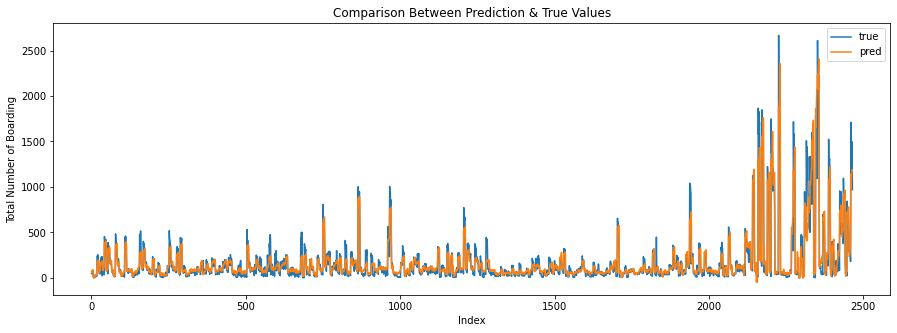

In [316]:
plt.figure(figsize=(15,5))
plt.plot(test_sum_y['NumberOfBoardings_sum'].values, label='true')
plt.plot(preds, label='pred')
plt.ylabel("Total Number of Boarding")
plt.xlabel("Index")
plt.title("Comparison Between Prediction & True Values")
plt.legend()
plt.show()


Results

we have trained the model for 48 weeks and test on last 6 weeks for all stopping points.
High Rmse value came because we didn't scale the values.so we got the actual prediction instead of scaled prediction

Using Gru

In [317]:
bb1['WeekBeginning'] = le.fit_transform(bb1['WeekBeginning'])

In [318]:
df = bb1.sort_values(['WeekBeginning','StopName'])

In [319]:
##Replace all Nan by Mode
for i in df.columns:
    df[i].fillna(df[i].mode()[0], inplace=True)
df[["postcode", "holiday_label"]] = df[["postcode", "holiday_label"]].apply(pd.to_numeric)

In [320]:
target_names = ['NumberOfBoardings_sum', 'NumberOfBoardings_count', 'NumberOfBoardings_max']
train_col = ['StopName','WeekBeginning','type_x','latitude','longitude','postcode','dist_from_centre','holiday_label']
##want to predict 1 day in future.
shift_days = 6
shift_steps = shift_days * 3249

In [321]:
df_targets = df[target_names].shift(-shift_steps)
x_data = df.iloc[:,1:].values[0:-shift_steps]
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (2700, 3)


In [322]:
##data split into 90% training and 10% testing
num_data = len(x_data)
train_split = 0.9
num_train = int(train_split * num_data)
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(len(x_train) + len(x_test))

2700


In [323]:
##target values for test and train
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(len(y_train) + len(y_test))
##input dimension and output dimension
num_x_signals = x_data.shape[1]
print(num_x_signals)
num_y_signals = y_data.shape[1]
print(num_y_signals)

2700
10
3


In [324]:
##scale data to get values between 0 to 1.
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print(x_train_scaled.shape)
print(y_train_scaled.shape)


Min: -37.838951
Max: 5554.0
Min: 0.0
Max: 1.0000000000000018
(2430, 10)
(2430, 3)


In [325]:
def batch_generator(batch_size, sequence_length):
    while True:
        # Allocate a new array for the batch of input,output signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        yield (x_batch, y_batch)

In [326]:
batch_size = 256
sequence_length = 1344
print(sequence_length)
generator = batch_generator(batch_size=batch_size,sequence_length=sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

1344
(256, 1344, 10)
(256, 1344, 3)


In [327]:
import keras

In [329]:
##model
model = Sequential()
model.add(LSTM(units=512,return_sequences=True,input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))

In [330]:
#loss function define.
warmup_steps = 0
def loss_mse_warmup(y_true, y_pred):
    # [batch_size, sequence_length, num_y_signals].
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    # Calculate the MSE loss for each value in these tensors.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,predictions=y_pred_slice)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [ ]:
##optimizer and model summary
optimizer = RMSprop(learning_rate=1e-3)
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [332]:
model.build(input_shape=(None, num_x_signals,))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, None, 512)         1071104   
_________________________________________________________________
dense_21 (Dense)             (None, None, 3)           1539      
Total params: 1,072,643
Trainable params: 1,072,643
Non-trainable params: 0
_________________________________________________________________


In [334]:
##early stopping and learning rate decrease callbacks
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=1)
callbacks = [callback_early_stopping]

**Future Work**


Calculateing the number of people commuting within a specific route.

Propose the means of commute based upon market information.